In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import json
import pycurl
from io import BytesIO
import numpy as np
from datetime import datetime
from datetime import timedelta

In [2]:
pd.options.mode.chained_assignment = None 

# Curve fitting notebook

uncertain parameters are: 


- probability of infection 0.06
- likelihood of awareness 0.1 0.034
- fraction of active contacts 0.54 0.8436
- maximum contacts allowed 32 53

start with probability of infection ...


### Actual infections

In [3]:
with open('cov_data.json') as json_file:
    cov_data = json.load(json_file)

In [4]:
dates = cov_data["RSA"]["Dates"][1:]
cape_town_cases = [int(x) for x in cov_data["RSA"]['City of Cape Town']['Cases']]
#western_cape_cases = [int(x) for x in cov_data["RSA"]['WC']['Cases']]

### plot actual infections ... + excess deaths

In [5]:
excess_deaths = pd.read_excel('samrc_excess_deaths_26_08_2020.xlsx', index_col=0)

c:\users\joerischasfoort\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


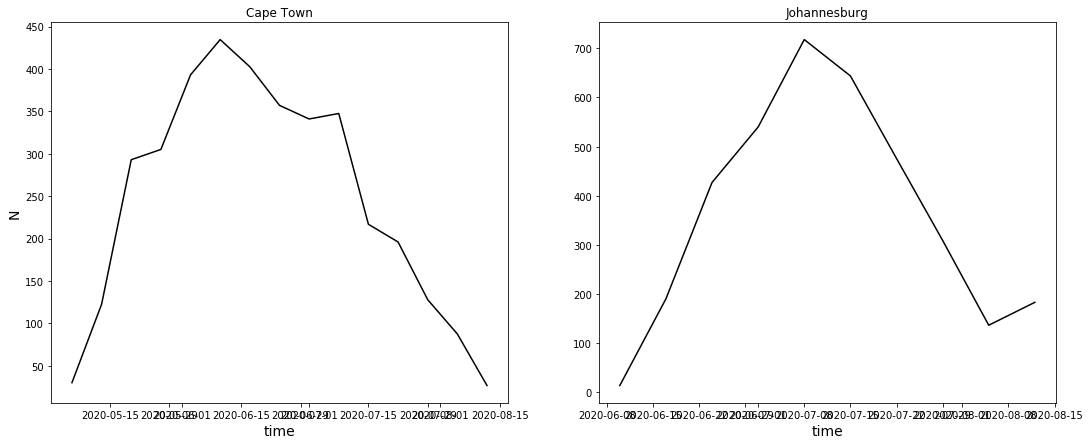

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))

ax1.plot(excess_deaths.index, excess_deaths['CPT'], 'k', label='excess_death')

ax1.set_ylabel('N', fontsize='14')
ax1.set_title('Cape Town')

ax2.plot(excess_deaths.index, excess_deaths['JHN'], 'k', label='excess_death')
ax2.set_title('Johannesburg')

for ax in (ax1, ax2):
    ax.set_xlabel('time', fontsize='14')
    
#fig.savefig('curve_fitting.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Moments of interest: 

1. Deaths
    1. total
    2. peak date
2. Critical cases
    1. max
    2. peak date
3. Recoveries (/ infections)
    1. total
4. New infections
    1. peak date
    2. max
    3. end date
    
### 1 Deaths 

#### A total

In [7]:
print('total excess deaths: ', 'CT: ', int(round(excess_deaths['CPT'].sum())), ' JHN: ', int(round(excess_deaths['JHN'].sum())))

total excess deaths:  CT:  3681  JHN:  3638


#### B Peak after first recorded death

In [8]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [9]:
peak_ct = str(excess_deaths['CPT'].idxmax())[:-9]
peak_jb = str(excess_deaths['JHN'].idxmax())[:-9]
first_ct = '2020-03-27' # source: https://www.news24.com/news24/southafrica/news/first-covid-19-deaths-we-mourn-as-a-province-and-country-western-cape-premier-alan-winde-20200327
first_jb = '2020-03-30' # source https://www.news24.com/news24/southafrica/news/coronavirus-79-year-old-man-is-gautengs-first-covid-19-death-20200331

In [10]:
print('peak excess death day: ', 'CT: ', days_between(peak_ct, first_ct), ' JHN: ', days_between(peak_jb, first_jb))

peak excess death day:  CT:  75  JHN:  100


### 2 Critical cases

In [11]:
population_ct = 3740026
population_jhn = 4474829
fraction_WC_in_CT= population_ct / 5823000 # source 2011 Census
fraction_GT_in_JHN = population_jhn / 12272263

In [12]:
ICU_CT = pd.Series([float(x) * fraction_WC_in_CT for x in cov_data["RSA"]['WC']['ICU']])
ICU_CT.index = cov_data["RSA"]["Dates"][:]
ICU_CT.index = [datetime.strptime(x + ' 2020', "%d %b %Y") for x in ICU_CT.index]

#### A Max

In [13]:
print('cape town max critical ', round(max(ICU_CT)))
print('joburg max critical not available ')

cape town max critical  229
joburg max critical not available 


#### B peak date

In [14]:
peak_critical_ct = str(ICU_CT.idxmax())[:-9]
peak_critical_ct

'2020-07-23'

In [15]:
print('peak ICU day: ', 'CT: ', days_between(peak_critical_ct, first_ct), ' JHN: not available')
print('probably wrong because there are now more cases outside of Cape Town')

peak ICU day:  CT:  118  JHN: not available
probably wrong because there are now more cases outside of Cape Town


In [16]:
peak_critical_day_ct = days_between(peak_critical_ct, first_ct)

### 3 Recoveries

#### A Total

#### Cape Town
From WC dashboard: https://coronavirus.westerncape.gov.za/covid-19-dashboard

and from this dashboard: https://www.covid19sa.org/western-cape

In [17]:
recoveries_27Aug = {'Tygerberg': 12102, 'Eastern': 9082, 'Southern': 8590, 'Western': 8430, 
                    'Klipfontein': 8162, 'Mitchels Plain': 7767, 'Khayelitsha': 7688, 'Northern': 6060}
CT_recoveries = sum(recoveries_27Aug.values())
CT_recoveries

67881

#### Johannesburg
From dashboard: https://www.covid19sa.org/gauteng, accessed 27 August

In [18]:
JHN_recoveries = 75310
print('total recoveries in Johannesburg is ', JHN_recoveries)

total recoveries in Johannesburg is  75310


### 4 New infections

Daily changes downloaded from https://www.covid19sa.org/ at August 27th 

In [19]:
gauteng_cases = pd.read_csv('Gauteng_Page 1_Time series.csv')
western_cape_cases = pd.read_csv('Western Cape  Page Design_Page 1_Time series.csv') 
western_cape_cases['Date'] = [datetime.strptime(western_cape_cases['Date'].iloc[x], "%b %d, %Y") for x in range(len(western_cape_cases['Date']))]
gauteng_cases['Date'] = [datetime.strptime(gauteng_cases['Day'].iloc[x], "%b %d, %Y") for x in range(len(gauteng_cases['Day']))]

In [20]:
joburg_cases = pd.Series([0 for x in range(9)] + [x for x in gauteng_cases['Johannesburg']])
city_cases = western_cape_cases[['Date', 'City Of Cape Town']]
city_cases['Johannesburg'] = joburg_cases
city_cases.index = city_cases['Date']
city_cases = city_cases[['City Of Cape Town', 'Johannesburg']].ewm(span = 10).mean()

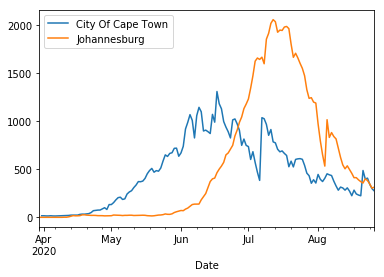

In [21]:
#city_cases.ewm(span = 10).mean().plot()
city_cases.plot()

### A peak date

In [22]:
peak_inf_ct = str(city_cases['City Of Cape Town'].idxmax())[:-9]
peak_inf_jb = str(city_cases['Johannesburg'].idxmax())[:-9]
first_case_ct = str(city_cases['City Of Cape Town'].index[0])[:-9]
first_case_jb = str(city_cases['Johannesburg'].index[11])[:-9]

In [23]:
print('peak new cases day: ', 'CT: ', days_between(peak_inf_ct, first_case_ct), ' JHN: ', days_between(peak_inf_jb, first_case_jb))

peak new cases day:  CT:  79  JHN:  93


### B max

In [24]:
print('peak cases: ', 'CT: ', int(round(city_cases['City Of Cape Town'].max())), ' JHN: ', int(round(city_cases['Johannesburg'].max())))

peak cases:  CT:  1308  JHN:  2056


### C end date

In [25]:
print('not yet')

not yet


### All moments



In [26]:
moments = {'1-A deaths total': [int(round(excess_deaths['CPT'].sum())), int(round(excess_deaths['JHN'].sum()))],
'1-B deaths peak day': [int(days_between(peak_ct, first_ct)), int(days_between(peak_jb, first_jb))],
'2-A critical max': [int(round(max(ICU_CT))), str(np.nan)],
'2-B critical peak day': [int(peak_critical_day_ct), str(np.nan)],
'3 recoveries total': [int(CT_recoveries), int(JHN_recoveries)],
'4-A infections peak day': [int(days_between(peak_inf_ct, first_case_ct)), int(days_between(peak_inf_jb, first_case_jb))],
'4-B max new daily infections': [int(round(city_cases['City Of Cape Town'].max())), int(round(city_cases['Johannesburg'].max()))],
'4-C last new infection': [str(np.nan), str(np.nan)]}

In [27]:
df_moments = pd.DataFrame(moments)
df_moments.index = ['CT', 'JHN']

In [28]:
df_moments = df_moments.transpose()
df_moments

,CT,JHN
1-A deaths total,3681,3638
1-B deaths peak day,75,100
2-A critical max,229,nan
2-B critical peak day,118,nan
3 recoveries total,67881,75310
4-A infections peak day,79,93
4-B max new daily infections,1308,2056
4-C last new infection,nan,nan


# Simulate and study moments

### Change parameters

In [29]:
with open('cape_town/parameters.json') as json_file:
    ct_param_file = json.load(json_file)

In [30]:
with open('johannesburg/parameters.json') as json_file:
    jb_param_file = json.load(json_file)

In [31]:
transmission_new = 0.0165
ct_param_file['probability_transmission'] = transmission_new
jb_param_file['probability_transmission'] = transmission_new

In [32]:
with open('config_ct.json', 'w') as outfile:
    json.dump(ct_param_file, outfile)

In [33]:
with open('config_jb.json', 'w') as outfile:
    json.dump(jb_param_file, outfile)

### Simulate CT

In [34]:
!sabcom simulate -i cape_town -o output_data/cape_town -s 3 -d csv-light -sc ineffective-lockdown -scf config_ct.json

scenario is  ineffective-lockdown
TOTAL RUNTIME 00:00:54.52
Simulation done, check out the output data here: output_data/cape_town


In [35]:
ct_data = pd.read_csv('output_data/cape_town/seed3quantities_state_time.csv', index_col=0)

In [36]:
ct_data = ct_data * population_ct / ct_param_file['number_of_agents']

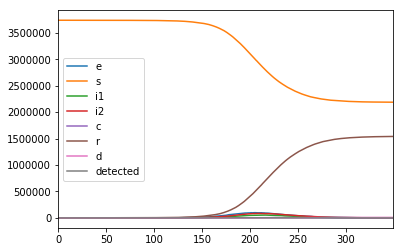

In [37]:
ct_data.plot()

Calculate moments for Cape Town simulation

### Simulate Joburg

In [38]:
!sabcom simulate -i johannesburg -o output_data/johannesburg -s 3 -d csv-light -sc ineffective-lockdown -scf config_jb.json

scenario is  ineffective-lockdown
TOTAL RUNTIME 00:00:56.93
Simulation done, check out the output data here: output_data/johannesburg


In [39]:
jb_data = pd.read_csv('output_data/johannesburg/seed3quantities_state_time.csv', index_col=0)

In [40]:
jb_data = jb_data * population_jhn / jb_param_file['number_of_agents']

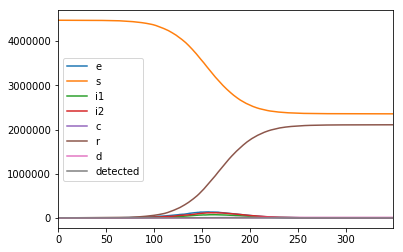

In [41]:
jb_data.plot()

### add to dataset

In [42]:
for df, name in zip([ct_data, jb_data], ['ct_sim', 'jhn_sim']):
    column = []
    #1-A deaths total
    column.append(int(round(df['d'].iloc[-1])))
    #1-B deaths peak day
    column.append(int(round(df['d'].diff().idxmax())))
    #2-A critical max
    column.append(int(round(max(df['c']))))
    #2-B critical peak day
    column.append(int(round(df['c'].idxmax())))
    #3 recoveries total
    column.append(int(round(df['r'].iloc[-1])))
    #4-A infections peak day
    column.append(int(round((df['i1'] + df['i2'] + df['c']).idxmax())))
    #4-B max new daily infections
    column.append(int(round((df['i1'] + df['i2'] + df['c']).max())))
    #4-C last new infection
    column.append(int(round(df['r'].idxmax())))
    df_moments[name] = column

In [43]:
int(round((df['i1'] + df['i2'] + df['c']).max()))

196445

In [44]:
df_moments

,CT,JHN,ct_sim,jhn_sim
1-A deaths total,3681,3638,9649,12306
1-B deaths peak day,75,100,214,164
2-A critical max,229,nan,5498,7473
2-B critical peak day,118,nan,220,163
3 recoveries total,67881,75310,1540704,2107197
4-A infections peak day,79,93,211,163
4-B max new daily infections,1308,2056,144290,196445
4-C last new infection,nan,nan,349,348


## Make excess death figure for curves: 

For deaths we have 98 days... from 2020-05-06 till 2020-08-12

infections... 
deaths

In [127]:
#df['d'].diff().ewm(span = 10).mean().plot()

In [132]:
# divide deaths evenly between dates 
# data point 1 and 2 
extended_excess_deaths = {}
for city in ['CPT', 'JHN']:
    excess_death_data = []
    for x in range(len(excess_deaths)-1):
        days = days_between(str(excess_deaths.index[x+1])[:-9], str(excess_deaths.index[x])[:-9])
        spread_out_data = [excess_deaths[city].iloc[x] / days for y in range(days)]
        excess_death_data.append(spread_out_data)
    excess_death_extended = [item for sublist in excess_death_data for item in sublist]
    excess_death_extended = pd.Series(excess_death_extended).ewm(span = 10).mean()
    extended_excess_deaths[city] = excess_death_extended

In [130]:
#extended_excess_deaths

{'CPT': 0      4.285714
 1      4.285714
 2      4.285714
 3      4.285714
 4      4.285714
 5      4.285714
 6      4.285714
 7     17.493759
 8     17.493759
 9     17.493759
 10    17.493759
 11    17.493759
 12    17.493759
 13    17.493759
 14    41.847772
 15    41.847772
 16    41.847772
 17    41.847772
 18    41.847772
 19    41.847772
 20    41.847772
 21    43.575737
 22    43.575737
 23    43.575737
 24    43.575737
 25    43.575737
 26    43.575737
 27    43.575737
 28    56.140664
 29    56.140664
         ...    
 68    49.634897
 69    49.634897
 70    30.969281
 71    30.969281
 72    30.969281
 73    30.969281
 74    30.969281
 75    30.969281
 76    30.969281
 77    27.989579
 78    27.989579
 79    27.989579
 80    27.989579
 81    27.989579
 82    27.989579
 83    27.989579
 84    18.268650
 85    18.268650
 86    18.268650
 87    18.268650
 88    18.268650
 89    18.268650
 90    18.268650
 91    12.490700
 92    12.490700
 93    12.490700
 94    12.490700
 95    

In [47]:
#excess_death_extended = [item for sublist in excess_death_data for item in sublist]

In [48]:
#excess_death_extended = pd.Series(excess_death_extended).ewm(span = 10).mean()

In [49]:
days_between(str(excess_deaths.index[-1])[:-9], str(excess_deaths.index[0])[:-9])

98

In [50]:
excess_deaths

,CPT,JHN
2020-05-06,30.000000,NaN
2020-05-13,122.456314,NaN
2020-05-20,292.934406,NaN
2020-05-27,305.030162,NaN
2020-06-03,392.984650,NaN
2020-06-10,434.596136,14.000000
2020-06-17,402.525723,190.321381
2020-06-24,357.048809,427.138068
2020-07-01,340.967995,539.969698
2020-07-08,347.444282,717.837786


### Start and end date of the simulations

The start date is the first date of the Cape Town simulation while the end date is the last date of the simulation of Joburg. 

In [51]:
# simulation CT starts at 2020-04-17 and ends at 14 March 2021
date1_ct = city_cases['City Of Cape Town'][city_cases['City Of Cape Town'].cumsum() > 310].index[0]

# simulation JHN starts at 2020-06-14 and ends at 
date1_jhn = city_cases['Johannesburg'][city_cases['Johannesburg'].cumsum() > 310].index[0]

In [52]:
start_date = date1_ct 
start_date

Timestamp('2020-04-17 00:00:00')

In [53]:
end_date = date1_jhn + timedelta(days=350)
end_date

Timestamp('2021-04-14 00:00:00')

In [54]:
#len(excess_death_extended)
# how to make simulated data and excess death data compatible 
#city_cases['Johannesburg'][city_cases['Johannesburg'].cumsum() > 310]
# how many days are there in the deaths series: 

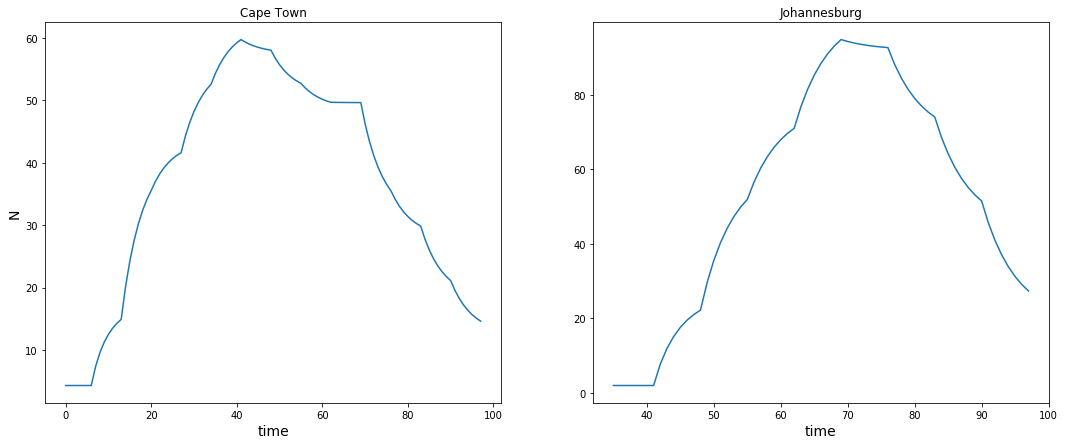

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))

ax1.plot(extended_excess_deaths['CPT'].index, extended_excess_deaths['CPT'])
#ax1.plot(excess_deaths.index, excess_deaths['CPT'], 'k', label='empirical')
#ax1.plot(df['d'].diff().index, df['d'].diff(), 'k', label='simulation')
#ax1.plot(excess_deaths.index, excess_deaths['CPT'], 'k', label='empirical')

ax1.set_ylabel('N', fontsize='14')
ax1.set_title('Cape Town')

ax2.plot(extended_excess_deaths['JHN'].index, extended_excess_deaths['JHN'])
#ax2.plot(excess_deaths.index, excess_deaths['JHN'], 'k', label='simulation')
ax2.set_title('Johannesburg')

for ax in (ax1, ax2):
    ax.set_xlabel('time', fontsize='14')

In [56]:
#excess_death_extended  # 2020-05-06 till 2020-08-12
# simulation ct = # #

# Create an all dates series

Use this series to anchor all graphs to the same timeline

In [143]:
#extended_excess_deaths['CPT'].index = [excess_deaths.index[0] + timedelta(days=x) for x in excess_death_extended.index]
#extended_excess_deaths

In [146]:
extended_excess_deaths['CPT'].index = [excess_deaths.index[0] + timedelta(days=x) for x in extended_excess_deaths['CPT'].index]
extended_excess_deaths['JHN'].index = [excess_deaths.index[0] + timedelta(days=x) for x in extended_excess_deaths['JHN'].index]

In [147]:
# how much to add at start: first date - start date 
# days_between(str(excess_deaths.index[x+1])[:-9], str(excess_deaths.index[x])[:-9])
ct_extra_days_start = days_between(str(start_date)[:-9], str(extended_excess_deaths['CPT'].index[0])[:-9]) 
ct_extra_days_end = days_between(str(extended_excess_deaths['CPT'].index[-1])[:-9], str(end_date)[:-9], )

In [148]:
# create time date stamps with timedelta(days=1)
all_dates = [start_date + timedelta(days=x) for x in range(0, ct_extra_days_start)] + [extended_excess_deaths['CPT'].index[0] + timedelta(days=x) for x in range(len(extended_excess_deaths['CPT']))] + [extended_excess_deaths['CPT'].index[-1] + timedelta(days=x) for x in range(1, ct_extra_days_end + 1)]#.iloc[-1]

# Extend data sets to make them fit on one graph:


### determine how much to: 
- add at the start
- add at the end 
### Then add 0s on both sides

start with excess death empirical 

# Create an all dates series

Use this series to anchor all graphs to the same timeline

Add: 

- excess deaths JB
- simulation JB
- simulation CT 

In [149]:
# generate series with index all_dates and 0 if not in own index and x if in index
def generate_new_series(old_series):
    new_series = []
    for d in all_dates:
        if d in old_series.index:
            new_series.append(old_series.loc[d])
        else:
            new_series.append(0)
    return new_series

In [150]:
# generate jb and ct sim data
jb_sim_deaths = jb_data['d'].diff().ewm(span = 10).mean()
ct_sim_deaths = ct_data['d'].diff().ewm(span = 10).mean()

In [151]:
# index is start date to end date.... ct 
ct_sim_deaths.index = [date1_ct + timedelta(days=x) for x in range(0, len(ct_sim_deaths))]

In [152]:
jb_sim_deaths.index = [date1_jhn + timedelta(days=x) for x in range(0, len(jb_sim_deaths))]

In [159]:
master_data = pd.DataFrame({
    'dates': all_dates,
    'excess_d_ct': generate_new_series(extended_excess_deaths['CPT']),
    'excess_d_jhn': generate_new_series(extended_excess_deaths['JHN']),
    'sim_d_ct':generate_new_series(ct_sim_deaths),
    'sim_d_jhn':generate_new_series(jb_sim_deaths),
})

In [160]:
#all_dates
death_data = pd.DataFrame(master_data)
death_data.index = death_data['dates']
death_data = death_data[['excess_d_ct', 'sim_d_ct', 'sim_d_jhn', 'excess_d_jhn']]

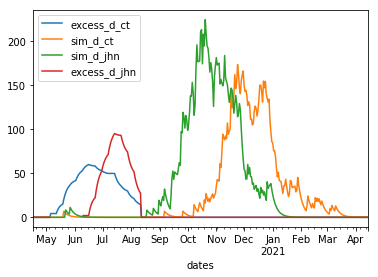

In [161]:
death_data.plot()

In [177]:
master_data = all_dates

In [175]:
master_data['dates'] = all_dates

In [160]:
len(pd.Series([0 for x in range(ct_extra_days_start)] + [x for x in range(len(excess_death_extended))] + [0 for x in range(ct_extra_days_end)]))

364

In [113]:
246 + 98 + 19

363

In [131]:
start_date

Timestamp('2020-04-17 00:00:00')

In [129]:
end_date

Timestamp('2021-04-14 00:00:00')